# Trade-off on downstream error: spherical harmonics example

In [1]:
from collections import defaultdict
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gegenbauer
from scipy import linalg as LA

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{mathtools}')
plt.rc('font', size=10, family='serif', serif='cm')


In [2]:
def rand_data(n, d):
    X = np.random.randn(n, d)
    return X / np.linalg.norm(X, axis=1)[:,None]

#### Symmetries

def block_cyclic(d, s):
    assert d % s == 0
    blocks = d // s
    sigma = np.arange(d)
    perm = sigma.copy()
    for shifts in product(*[range(s)] * blocks):
        for i, shift in enumerate(shifts):
            perm[i*s:(i+1)*s] = np.roll(sigma[i*s:(i+1)*s], shift)
        yield perm


def get_perms(group, d):
    if group == 'cyclic':
        return block_cyclic(d, d)
    elif group.startswith('loc_'): # (not a group... also only works with shift=1, rest is TODO)
        return [np.arange(d), np.roll(np.arange(d), -1), np.roll(np.arange(d), 1)]
    else:
        assert False


def symmetrize(f, group='perm'):
    def newf(X):
        numperm = 0
        out = 0.
        for perm in get_perms(group, X.shape[1]):
            out += f(X[:,perm])
            numperm += 1
        return out / numperm
    return newf

##### (downstream) target functions

def target_gegen(X, deg=3, group=None):
    d = X.shape[1]
    pk = gegenbauer(deg, d / 2 - 1)

    def f(X):
        return pk(X[:,0])
    return symmetrize(f, group=group)(X) if group else f(X)


In [3]:
#### Aruguments
max_shift = 1
# log_lambda_min = -5

d = 8
k = 20
n = 2000         # n = n_train + n_test
n_train = 300

In [4]:
np.random.seed(42)
naug = 1 + 2 * max_shift  # identity + shifts in both directions
X = rand_data(n, d).astype(np.float32)

labels = [r'$\ell=1$ non-inv.', r'$\ell=3$, inv.']
ys = []
ys.append(target_gegen(X, 1, group='loc_1'))
ys.append(target_gegen(X, 3, group='cyclic'))

ys_train = []
ys_test = []
for y in ys:
    ytr, yte = y[:n_train], y[n_train:]
    ys_train.append(ytr)
    ys_test.append(yte)

X_train, X_test = X[:n_train], X[n_train:]
X_aug = [X_train.copy()]
for shift in range(1, max_shift + 1):
    perm = np.roll(np.arange(d), shift)
    X_aug.append(X_train[:,perm])
    perm = np.roll(np.arange(d), -shift)
    X_aug.append(X_train[:,perm])

X_aug = np.concatenate(X_aug)
n_aug = X_aug.shape[0]


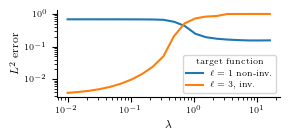

In [5]:
T = np.kron(1. - np.eye(naug), np.eye(n_train))

ssl_lmbdas = np.logspace(-2, 1.2, num=20)
lmbdas = np.logspace(-5, 0, num=10)

#### Kernels

def kappa1(u):
    return (np.sqrt(1 - u**2) + u * (np.pi - np.arccos(u))) / np.pi

def kappa1b(u):
    return (1. + u) * kappa1(u)

kernel_fn = kappa1b
Kfull = kernel_fn(X_aug.dot(X_aug.T).clip(min=-1.,max=1.))
Kfull_tr = kernel_fn(X_aug.dot(X_train.T).clip(min=-1., max=1.))
Kfull_te = kernel_fn(X_aug.dot(X_test.T).clip(min=-1., max=1.))

#### Training 
Kinv = LA.pinvh(Kfull + 1e-4 * np.eye(Kfull.shape[0]))

errs = defaultdict(list)
for lmbda_ssl in ssl_lmbdas:
    Tl = T - lmbda_ssl * Kinv
    e, C = LA.eigh(Tl, subset_by_index=[len(Tl) - k, len(Tl) - 1])
    ind = e > 0
    C = C[:, ind]  # remove negative eigenvalues

    phi_test = Kfull_te.T @ (Kinv @ C)
    phi_train = Kfull_tr.T @ (Kinv @ C)

    for target, ytr, yte in zip(labels, ys_train, ys_test):
        valid_errs = []
        for lmbda in lmbdas:
            preds = phi_test.dot(np.linalg.solve(phi_train.T.dot(phi_train) + n_train * lmbda * np.eye(C.shape[1], dtype=phi_train.dtype), phi_train.T.dot(ytr)))
            err = np.mean((preds - yte) ** 2) / np.mean(yte ** 2)
            valid_errs.append(err)
        errs[target].append(np.min(valid_errs))

#### Display

fig, ax = plt.subplots(1, 1, figsize=(3,1.5))
i = 0
for target, err in errs.items():
    i += 1
    if i in [1, 2]:
        ax.loglog(ssl_lmbdas, err, label=target)

#    ax.set_title('Trade-off on downtream errors', fontsize=10)
ax.set_xlabel(r'$\lambda$', fontsize=8)
ax.set_ylabel(r'$L^2$ error', fontsize=8)
ax.tick_params(axis="both", which="major", labelsize=6)
# ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=6, ncol=1, title='target function', title_fontsize=6)
fig.tight_layout()
# fig.savefig('ssl_8_1.pdf', bbox_inches='tight')